In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import sys
sys.path.append("../")
from PythonCode.preprocess.preprocess import *
from PythonCode.preprocess.complexStyleFeatures import *
from PythonCode.preprocess.simpleStyleFeatures import *
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import pickle 
import gensim.downloader
from pprint import pprint
DATA_PATH_TRAIN = "../Data/C50/C50train/"
DATA_PATH_TEST = "../Data/C50/C50test/"

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Simple

In [2]:
df_train = load_data("../Data/C50/C50train",50)
df_train

,author_name,book_name,book_text
0,AaronPressman,106247newsML.txt,The Internet may be overflowing with new techn...
1,AaronPressman,120600newsML.txt,The U.S. Postal Service announced Wednesday a ...
2,AaronPressman,120683newsML.txt,Elementary school students with access to the ...
3,AaronPressman,136958newsML.txt,An influential Internet organisation has backe...
4,AaronPressman,137498newsML.txt,An influential Internet organisation has backe...
...,...,...,...
2495,WilliamKazer,28223newsML.txt,China's central bank chief has said that infla...
2496,WilliamKazer,282935newsML.txt,"China ushered in 1997, a year it has hailed as..."
2497,WilliamKazer,287736newsML.txt,China issued tough new rules on the handling o...
2498,WilliamKazer,289747newsML.txt,China will avoid bold moves in tackling its ai...


In [5]:
df_test = load_data("../Data/C50/C50test",50)
df_test

,author_name,book_name,book_text
0,AaronPressman,421829newsML.txt,U.S. Senators on Tuesday sharply criticized a ...
1,AaronPressman,424074newsML.txt,Two members of Congress criticised the Federal...
2,AaronPressman,42764newsML.txt,Commuters stuck in traffic on the Leesburg Pik...
3,AaronPressman,43033newsML.txt,A broad coalition of corporations went to Capi...
4,AaronPressman,433558newsML.txt,"On the Internet, where new products come and g..."
...,...,...,...
2495,WilliamKazer,504283newsML.txt,China has scored new successes in its fight ag...
2496,WilliamKazer,504526newsML.txt,China has scored new successes in its fight ag...
2497,WilliamKazer,51502newsML.txt,China is on target with plans to to promote 10...
2498,WilliamKazer,522090newsML.txt,China may need to adjust the mix of its treasu...


In [7]:
df = df_train.append(df_test, ignore_index=True)

In [9]:
TEST_PART = 0.1

## Baseline

### Pre

In [10]:
X_train,X_test,y_train,y_test = train_test_split(df["book_text"],df["author_name"],test_size=TEST_PART)

In [20]:
def avg_word_len(df: pd.DataFrame) -> pd.DataFrame:
    avg_word_len = df.astype(str).swifter.apply(
        lambda s: pd.Series(nltk.word_tokenize(s)).map(len).mean()).rename("avg_word_len")
    return pd.DataFrame(avg_word_len)


def avg_sentence_len(df: pd.DataFrame) -> pd.DataFrame:
    sentence_count = df.astype(str).swifter.apply(
        lambda text: pd.Series(nltk.sent_tokenize(text)).map(
            lambda sent: len(nltk.word_tokenize(sent))).mean()).rename("avg_sentence_len")

    return pd.DataFrame(sentence_count)

def hapax_disLegemena(x: pd.DataFrame) -> pd.DataFrame:
    """
    hapax disLegemena Measure for lexicographic diversity: v2/N
    v2 = number of words that appears twice
    N = number of words or number of unique words
    """

    def get_hapax_disLegemena(text: str) -> (float, float):
        words = nltk.word_tokenize(text)
        words_count = Counter(words)
        v2 = len([_ for _, count in words_count.items() if count == 2])
        return pd.Series((v2 / (len(words) + EPSILON), v2 / (len(set(words))+EPSILON)))

    return pd.DataFrame(x.astype(str).swifter.apply(get_hapax_disLegemena)).set_axis(['hapax_disLegemena(H)', 'hapax_disLegemena(S)'], axis=1)


In [21]:
def preprocess(x_train: pd.DataFrame, x_test: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    def helper(x: pd.DataFrame) -> pd.DataFrame:
        return pd.concat([avg_word_len(x),avg_sentence_len(x),hapax_disLegemena(x)], axis=1)
        
    return helper(x_train), helper(x_test)

X_train,X_test = preprocess(X_train,X_test)

Pandas Apply:   0%|          | 0/4500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
y_train = pd.Categorical(y_train).codes
y_test = pd.Categorical(y_test).codes

### Model

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100,max_depth=7, random_state=0)
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=7, random_state=0)

In [25]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.17      0.40      0.24         5
           1       0.30      0.23      0.26        13
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        10
           4       0.09      0.11      0.10         9
           5       0.00      0.00      0.00         8
           6       0.10      0.09      0.10        11
           7       0.16      0.23      0.19        13
           8       0.22      0.20      0.21        10
           9       0.12      0.12      0.12         8
          10       0.07      0.14      0.09         7
          11       0.00      0.00      0.00        10
          12       0.14      0.08      0.11        12
          13       0.06      0.20      0.09         5
          14       0.00      0.00      0.00         9
          15       0.38      0.23      0.29        13
          16       0.10      0.07      0.08        14
          17       0.08    

# Using Glove

In [13]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [27]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [28]:
len(glove_vectors)

400000

In [185]:
import re
# lemmatizer = nltk.stem.WordNetLemmatizer()
# stemmer = nltk.stem.PorterStemmer()
def tranform_word(word:str) -> np.ndarray:
    word = re.sub(r'[^a-z]', '', word.lower())
    if word in glove_vectors:
        return glove_vectors[word]
#     if not simple:
#         token = lemmatizer.lemmatize(word)
#         if token in glove_vectors:
#             return glove_vectors[token]
#         token = stemmer.stem(word)
#         if token in glove_vectors:
#             return glove_vectors[token]
    return None

In [277]:
EMBEDDING_SIZE = 50

## Sentence Level

### Preprocess

In [197]:
X_train,X_test,y_train,y_test = train_test_split(df["book_text"],df["author_name"],test_size=TEST_PART)

In [198]:
def num_sentences_based_chucking(df: pd.DataFrame, chunk_size: int):
    rows = []
    for row in df:
        sentences = nltk.tokenize.sent_tokenize(row)
        curr_chunk = []
        for sentence in sentences:
            curr_chunk.append(sentence)
            if len(curr_chunk) == chunk_size:
                rows.append("".join(curr_chunk))
                curr_chunk = []
        
        rows.append("".join(curr_chunk))  # add the last one
    return pd.DataFrame(rows)

In [199]:
NUM_OF_SENTENCE_CHUNK = 3
X_train = num_sentences_based_chucking(X_train,NUM_OF_SENTENCE_CHUNK)[0]
X_test = num_sentences_based_chucking(X_test,NUM_OF_SENTENCE_CHUNK)[0]
X_train.shape,X_test.shape

((35535,), (3934,))

#### Decide max number of words

In [116]:
num_words = X_train.swifter.apply(lambda text: len(nltk.word_tokenize(text)))
num_words.describe()

Pandas Apply:   0%|          | 0/35525 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1675: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


count    35525.000000
mean        70.791893
std         28.567110
min          0.000000
25%         56.000000
50%         73.000000
75%         90.000000
max        307.000000
Name: 0, dtype: float64

In [120]:
num_words.quantile([0.95,0.97,0.98,0.99])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1675: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


0.95    113.00
0.97    118.00
0.98    122.52
0.99    128.00
Name: 0, dtype: float64

In [142]:
num_words[num_words>170]

1353     179
15730    307
21318    195
33340    209
Name: 0, dtype: int64

In [143]:
MAX_LENGTH = 170

#### Continue Preprocess

In [228]:
def pad_matrix(arr:np.ndarray,max_length:int) -> np.ndarray:
    if arr.size == 0:
        return None
    if arr.shape[0] == max_length:
        return arr
    if arr.shape[0] > max_length:
        return arr[:max_length,:]
    return np.concatenate([arr,np.zeros((max_length - arr.shape[0],arr.shape[1]))],axis=0,dtype=float)

In [268]:
def sentence_level_preprocess(text:str):
    words = nltk.word_tokenize(text)
    result = []
    missing_embedding_count = 0
    for word in words:
        embedding = tranform_word(word)
        if embedding is not None:
            result.append(embedding)
        else:
            missing_embedding_count+=1
    return pd.Series({"data": pad_matrix(np.array(result),MAX_LENGTH),"missing_embedding_count":missing_embedding_count})

In [230]:
res = X_test.swifter.apply(sentence_level_preprocess)
# res['missing_embedding_count'].describe()

Pandas Apply:   0%|          | 0/3934 [00:00<?, ?it/s]

In [281]:
def preprocess(X):
#     X_train = num_sentences_based_chucking(X_train,NUM_OF_SENTENCE_CHUNK)[0]
    res = X.swifter.apply(sentence_level_preprocess)["data"].dropna().reset_index(drop=True)
    return np.vstack(res).reshape((res.size,MAX_LENGTH,EMBEDDING_SIZE))
#X_train,X_test,y_train,y_test = train_test_split(df["book_text"],df["author_name"],test_size=TEST_PART)

In [282]:
X_test = preprocess(X_test)
X_train = preprocess(X_train)

Pandas Apply:   0%|          | 0/3934 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/35535 [00:00<?, ?it/s]

**Note that we tried to stemm or lemmatize the word before search in glove table but it doesnt help at all**

In [283]:
X_train.shape

(34049, 170, 50)

### Model

In [396]:
from tensorflow.keras.layers import Dense,GRU,AvgPool1D
import tensorflow as tf
from tensorflow.keras.models import Sequential
import pickle

model = Sequential()
model.add(GRU(100,recurrent_dropout=0.2,input_shape=(MAX_LENGTH,EMBEDDING_SIZE),return_sequences=True))
model.add(AvgPool1D(pool_size=(170,)))
model.add(Dense(50, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (None, 170, 100)          45600     
_________________________________________________________________
average_pooling1d_6 (Average (None, 1, 100)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 50)             5050      
Total params: 50,650
Trainable params: 50,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
history = model.fit(x=X_train, y=y_train, epochs=200, shuffle=True,
          batch_size=200, validation_data=(X_val, y_val),callbacks=[callback])
with open("sentence_level-history") as file:
    pickle.dump(history, file)

In [ ]:
model.save("sentence_level")

## Article Level

### Preprocess
**Problems:**
1. tranform words without glove embedding
2. unequal setence length(padding required)

In [290]:
X_train,X_test,y_train,y_test = train_test_split(df["book_text"],df["author_name"],test_size=TEST_PART)

#### Decide Max Setence Length

In [298]:
def get_number_of_words_per_sentence(text):
    sentences = nltk.sent_tokenize(text)
    results = []
    for sentence in sentences:
        results.append(len(nltk.word_tokenize(sentence)))
    return pd.Series(results)

In [325]:
res = X_train.swifter.apply(get_number_of_words_per_sentence).fillna(0)
res.describe()

Pandas Apply:   0%|          | 0/4500 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1675: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1675: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1608: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'n

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
count,4500.000000,4500.000000,4493.000000,4477.000000,4464.000000,4458.000000,4449.000000,4437.000000,4420.000000,4401.000000,...,4.000000,2.000000,2.000000,2.000000,2.00000,2.000000,1.0,1.0,1.0,1.0
mean,33.978667,33.950667,29.005787,28.066786,27.333333,27.319874,26.908294,26.715574,26.429638,26.756646,...,20.750000,29.500000,23.500000,19.000000,15.50000,18.000000,32.0,25.0,16.0,12.0
std,7.419898,10.797692,11.367748,11.413300,11.216505,11.197333,10.909027,10.903411,11.018131,10.973236,...,5.560276,0.707107,0.707107,5.656854,2.12132,16.970563,NaN,NaN,NaN,NaN
min,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,...,13.000000,29.000000,23.000000,15.000000,14.00000,6.000000,32.0,25.0,16.0,12.0
25%,30.000000,27.000000,20.000000,20.000000,19.000000,19.000000,19.000000,19.000000,18.000000,19.000000,...,19.000000,29.250000,23.250000,17.000000,14.75000,12.000000,32.0,25.0,16.0,12.0
50%,34.000000,34.000000,29.000000,28.000000,27.000000,27.000000,26.000000,26.000000,26.000000,26.000000,...,22.000000,29.500000,23.500000,19.000000,15.50000,18.000000,32.0,25.0,16.0,12.0
75%,38.000000,41.000000,37.000000,35.000000,35.000000,35.000000,34.000000,34.000000,34.000000,34.000000,...,23.750000,29.750000,23.750000,21.000000,16.25000,24.000000,32.0,25.0,16.0,12.0
max,107.000000,95.000000,87.000000,95.000000,102.000000,114.000000,86.000000,80.000000,90.000000,111.000000,...,26.000000,30.000000,24.000000,23.000000,17.00000,30.000000,32.0,25.0,16.0,12.0


<AxesSubplot:>

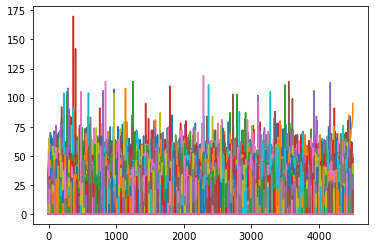

In [336]:
res.fillna(0).sort_values(by=1).reset_index(drop=True).plot(legend=False)

In [350]:
values = [50,70,75,80,85,90,100,150]
for val in values:
    print(f"val: {val} => {res[res < val].isna().sum().sum()/res.size * 100}")

val: 50 => 0.7353233830845771
val: 70 => 0.0693200663349917
val: 75 => 0.04245439469320066
val: 80 => 0.025538971807628524
val: 85 => 0.015588723051409618
val: 90 => 0.011608623548922056
val: 100 => 0.007960199004975124
val: 150 => 0.0003316749585406302


In [370]:
MAX_SENTENCE_LENGTH = 70
MAX_NUMBER_OF_SENTENCE = 45

In [363]:
def pad_array(arr, pad_size): # TODO: reuse pad_matrix instead
    if arr.size == pad_size:
        return arr
    elif arr.size > pad_size:
        return arr[:pad_size,]
    return np.concatenate([arr,np.zeros(pad_size - arr.size)],dtype=float)

In [371]:
def article_level_preprocess(text):
    sentences = nltk.sent_tokenize(text)
    result = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        curr_result = []
        for word in words:
            embedding = tranform_word(word)
            if embedding is not None:
                curr_result.append(embedding)
        if len(curr_result) != 0:
            result.append(pad_array(np.array(curr_result,dtype=float).mean(axis=1,dtype=float),MAX_SENTENCE_LENGTH))
    return pad_matrix(np.array(result),MAX_NUMBER_OF_SENTENCE)

In [381]:
def preprocess(X):
    res = X.swifter.apply(article_level_preprocess).reset_index(drop=True)
    return np.vstack(res).reshape((res.size,MAX_NUMBER_OF_SENTENCE,MAX_SENTENCE_LENGTH))
X_train = preprocess(X_train)
X_test = preprocess(X_test)

Pandas Apply:   0%|          | 0/4500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

### Model

In [ ]:
from tensorflow.keras.layers import Dense,GRU,AvgPool2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(GRU(100,recurrent_dropout=0.5,input_shape=(100,1)))
model.add(AvgPool2D())
model.add(Dense(50, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
history = model.fit(x=X_train, y=y_train, epochs=200, shuffle=True,
          batch_size=200, validation_data=(X_test, y_test),callbacks=[callback])

In [ ]:
model.save("article_level")